In [73]:
import random

import cv2
import numpy as np
from PIL import Image
import os
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import classification_report,  confusion_matrix
import seaborn as sns
import warnings
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

warnings.filterwarnings("ignore")


# Part 1

In [74]:
# Reading images
root_path = "C:\\Users\\user\\PycharmProjects\\pythonProject\\Dataset1"
image_data = []  # List to store image data

# Iterate through files in the specified directory
for file in os.listdir(root_path):
    # Read image and convert it to a NumPy array
    image = np.array(Image.open(os.path.join(root_path, file)))

    # Flatten the image and append it to the list
    image_data.append(image.flatten())

# Convert the list of flattened images to a NumPy array
M = np.array(image_data).T  # Transpose to change shape from 11x65536 to 65536x11

# Print the shape of the array
print("Shape of the image data array:", M.shape)

Shape of the image data array: (65536, 11)


In [75]:
# Calculate the mean of each image along the axis 0 (column-wise)
img_means = M.mean(axis=0)

# Reshape the mean array to correct format (1 row, as many columns as images)
img_means = img_means.reshape(1, -1)

print(f"Shape of img_means {img_means.shape}")

Shape of img_means (1, 11)


In [76]:
# Subtract the mean of each image from the original image data
D = M - img_means

print(f"Shape of normalized imgs {D.shape}")

Shape of normalized imgs (65536, 11)


In [77]:
# Calculate the sample covariance matrix
covar_matrix = np.dot(D.T, D)

# Print the shape of the covariance matrix
print("Shape of the covariance matrix:", covar_matrix.shape)

Shape of the covariance matrix: (11, 11)


In [78]:
# Calculate eigenvalues and eigenvectors of the covariance matrix
eigen_values, eigen_vectors = np.linalg.eig(covar_matrix)

# Print the eigenvalues and the shape of the eigenvectors
print("Eigenvalues:", eigen_values)
print("Shape of Eigenvectors Matrix:", eigen_vectors.shape)


Eigenvalues: [6.45269237e+09 3.61788877e+08 1.55372492e+08 1.21129684e+08
 9.91281765e+07 2.90717822e+07 7.96245923e+07 6.86769042e+07
 5.41515771e+07 4.31537980e+07 4.82669661e+07]
Shape of Eigenvectors Matrix: (11, 11)


In [79]:
# Sort eigenvectors according to eigenvalues in descending order
sorted_indices = np.argsort(eigen_values)[::-1]
sorted_eigenvalues = eigen_values[sorted_indices]
sorted_eigenvectors = eigen_vectors[:, sorted_indices]

# Choose the first n eigenvectors (for example, n=3 in this case)
n = 3
selected_eigenvectors = sorted_eigenvectors[:, :n]

# Print the shape of the selected eigenvectors
print("Shape of Selected Eigenvectors Matrix:", selected_eigenvectors.shape)

Shape of Selected Eigenvectors Matrix: (11, 3)


In [80]:
# Getting projection matrix via matrix multiplication of normalized images and eigenvectors
I = np.dot(D, selected_eigenvectors)

# Print the shape of the projection matrix
print("Shape of the Projection Matrix I:", I.shape)

Shape of the Projection Matrix I: (65536, 3)


In [81]:
# Compressing all images from 11x65536 to 3x11 using the projection matrix
compressed_images = np.dot(I.T, D)

# Print the shape of the compressed images
print("Shape of Compressed Images Matrix:", compressed_images.shape)

Shape of Compressed Images Matrix: (3, 11)


Values of the Compressed Image: [ 1.92019607e+09 -7.46241818e+07 -2.38975002e+07]


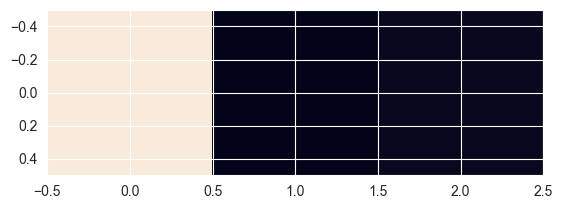

In [82]:
# Display an example of a compressed image (may not make sense with just 3 features)
example_compressed_image = compressed_images.T[0].reshape(1, 3)
# Display the compressed image using matplotlib
plt.imshow(example_compressed_image)
plt.savefig("example_compressed.jpg")

# Print the values of the compressed image
print("Values of the Compressed Image:", compressed_images.T[0])

# Part 2

In [83]:
def extract_color_histogram(image):
    """
    Extracts color histograms for each color channel (R, G, B) from the input image.

    Parameters:
    - image: NumPy array representing the image.

    Returns:
    Tuple of histograms for each color channel (histogram_R, histogram_G, histogram_B).
    """
    # Initialize histograms for each color channel (R, G, B)
    histogram_R = np.zeros(256, dtype=int)
    histogram_G = np.zeros(256, dtype=int)
    histogram_B = np.zeros(256, dtype=int)

    # Iterate through the image and update channel-specific bin counts
    for row in image:
        for pixel in row:
            r, g, b = pixel  # Extract RGB values
            histogram_R[r] += 1
            histogram_G[g] += 1
            histogram_B[b] += 1

    return histogram_R, histogram_G, histogram_B


def calculate_distances(query_data, database_data):
    """
    Calculates Euclidean distances between each query feature and each database feature.

    Parameters:
    - query_data: List of tuples containing query features and labels.
    - database_data: List of tuples containing database features and labels.

    Returns:
    Tuple of distances and indices of similar images.
    """
    distances = []
    indices_of_similar_images = []

    for query_feature, query_label in query_data:
        for database_feature, database_label in database_data:
            # Calculate Euclidean distance between the query feature and the database feature
            distance = np.sqrt(np.sum((query_feature - database_feature) ** 2))
            distances.append(distance)
            indices_of_similar_images.append(database_label)

    return distances, indices_of_similar_images



def generate_ranked_list(query_data, database_data, top_k=30):
    """
    Generates a ranked list of results based on distances between query and database features.

    Parameters:
    - query_data: List of tuples containing query features and labels.
    - database_data: List of tuples containing database features and labels.
    - top_k: Number of top results to retrieve (default is 30).

    Returns:
    List of tuples containing distances, class indices, and class labels for the top-k results.
    """
    distances, indices_of_similar_images = calculate_distances(query_data, database_data)

    # Create a list of tuples containing distances, class indices, and class labels
    ranked_results = [(distances[i], indices_of_similar_images[i], idx2label[indices_of_similar_images[i]]) for i in range(len(distances))]

    # Sort the results based on distances
    ranked_results.sort(key=lambda x: x[0])

    # Retrieve the top-k results
    top_k_results = ranked_results[:top_k]

    return top_k_results


In [84]:
# Load the dataset images and extract features
dataset_dir = "Dataset2"
query_dir = "QUERY_IMAGES"

# Dictionaries for accessing class names and indexes to be used later on
label2idx = {
    'airplane': 0,
    'bear': 1,
    'blimp': 2,
    'bonsai': 3,
    'cactus': 4,
    'dog': 5,
    'goat': 6,
    'goose': 7,  # called goose in query_dir
    'googse': 7,
    'ibis': 8,
    'iris': 9
}
idx2label = {v: k for k, v in label2idx.items()}

# Set the target baseline size for resizing images to the same sizes
target_height = 128
target_width = 128

# Create a list of tuples containing flattened histograms and class labels
database_features = []

# Reading dataset images
for folder in os.listdir(dataset_dir):
    if folder != query_dir:
        for image_file in os.listdir(os.path.join(dataset_dir, folder)):
            img = cv2.imread(os.path.join(dataset_dir, folder, image_file),cv2.COLOR_BGR2RGB)
            img = cv2.resize(img,(target_width, target_height))
            img_array = np.array(img)

            # Extract color histograms
            histogram_R, histogram_G, histogram_B = extract_color_histogram(img_array)
            flattened_histogram = np.concatenate([histogram_R, histogram_G, histogram_B])

            # Append tuple of flattened histogram and class label to the database_features list
            database_features.append((flattened_histogram, label2idx[folder]))

# Example format: a tuple with a 768-dimensional array for histogram at index 0 and the label at index 1.
print(f"Example data entry histogram shape: {database_features[0][0].shape}")
print(f"Example data entry label: {database_features[0][1]}")

Example data entry histogram shape: (768,)
Example data entry label: 0


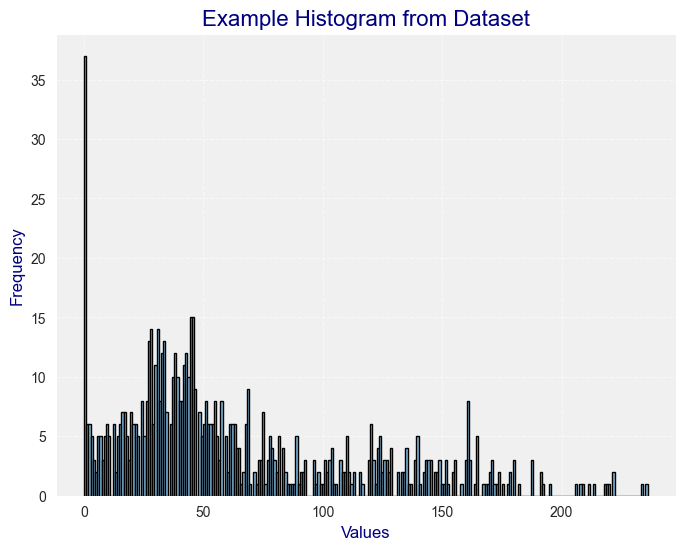

In [85]:
# Let's show an example histogram plot from a data
data = database_features[0][0]

fig, ax = plt.subplots(figsize=(8, 6))
# Plot the histogram with customizations
ax.hist(data, bins=256, color="#7eb8da", edgecolor='black')  # Light blue color

# Add labels and title
ax.set_title("Example Histogram from Dataset", fontsize=16, color="navy")
ax.set_xlabel("Values", fontsize=12, color="navy")
ax.set_ylabel("Frequency", fontsize=12, color="navy")
ax.set_facecolor("#f0f0f0")
ax.grid(True, linestyle='--', alpha=0.6)
plt.savefig("example_histogram.jpg")
plt.show()

In [86]:
# Load the query images and extract features
query_features = []

for filename in os.listdir(os.path.join(dataset_dir, query_dir)):
    img = cv2.imread(os.path.join(dataset_dir, query_dir, filename),cv2.COLOR_BGR2RGB)
    img = cv2.resize(img,(target_width, target_height))
    img = np.array(img)

    # Extract color histograms
    histogram_R, histogram_G, histogram_B = extract_color_histogram(img)
    flattened_histogram = np.concatenate([histogram_R, histogram_G, histogram_B])

    # Extract class label from the filename (assuming filenames contain class information)
    class_label = label2idx[filename.split('_')[0].lower()]  # Assuming filenames are in the format "class_1.jpg"

    # Append tuple of flattened histogram and class label to the query_features list
    query_features.append((flattened_histogram, class_label))

# Example format: a tuple with a flattened 768-dimensional histogram at index 0 and the label at index 1.
print(f"Example data entry histogram shape: {query_features[0][0].shape}")
print(f"Example data entry label: {query_features[0][1]}")

Example data entry histogram shape: (768,)
Example data entry label: 0


In [87]:
# Distance calculation and ranking indexes and labels of most similar images
all_ranked_indices = []  # Ranked class indexes
all_ranked_labels = []  # Ranked class indexes converted into labels
all_distances = []  # Ranked distances

# Iterate over each query image
for query_item in query_features:
    # Getting ranked results for the current query image
    ranked_results = generate_ranked_list(query_data=[query_item], database_data=database_features, top_k=300)

    # Extract distances, image indices, and class labels from the ranked results
    distances = [result[0] for result in ranked_results]
    image_indices = [result[1] for result in ranked_results]
    image_labels = [result[2] for result in ranked_results]

    # Append the extracted information for the current query image
    all_ranked_indices.append(image_indices)
    all_ranked_labels.append(image_labels)
    all_distances.append(distances)

# Convert the lists to NumPy arrays for further analysis
all_ranked_indices = np.array(all_ranked_indices)
all_ranked_labels = np.array(all_ranked_labels)
all_distances = np.array(all_distances)
# 'all_ranked_labels' now contains the class labels for the top-k retrieved images for each query


# Create column names for the DataFrame
column_names = [f"ranked_{i + 1}" for i in range(300)]
df_all_ranked_labels = pd.DataFrame(all_ranked_labels, columns=column_names)

# Add a column for the query image label
query_labels = [idx2label.get(label) for _,label in query_features]
df_all_ranked_labels.insert(0, 'query_label', query_labels)

display(df_all_ranked_labels)

,query_label,ranked_1,ranked_2,ranked_3,ranked_4,ranked_5,ranked_6,ranked_7,ranked_8,ranked_9,...,ranked_291,ranked_292,ranked_293,ranked_294,ranked_295,ranked_296,ranked_297,ranked_298,ranked_299,ranked_300
0,airplane,airplane,airplane,airplane,airplane,airplane,airplane,bonsai,airplane,airplane,...,blimp,blimp,iris,blimp,dog,blimp,bonsai,blimp,blimp,iris
1,airplane,airplane,airplane,dog,airplane,goat,ibis,goat,goat,dog,...,bonsai,iris,blimp,dog,blimp,blimp,bonsai,blimp,blimp,iris
2,bear,cactus,goat,goat,cactus,googse,cactus,goat,cactus,goat,...,blimp,bonsai,bonsai,blimp,bonsai,blimp,blimp,blimp,blimp,iris
3,bear,googse,bear,ibis,goat,goat,ibis,googse,dog,googse,...,blimp,bonsai,bonsai,blimp,bonsai,blimp,blimp,blimp,blimp,iris
4,blimp,bear,dog,airplane,bonsai,ibis,googse,dog,iris,cactus,...,bonsai,blimp,bonsai,blimp,bonsai,blimp,blimp,blimp,blimp,iris
5,blimp,dog,bear,cactus,cactus,bonsai,dog,goat,googse,ibis,...,blimp,dog,bonsai,blimp,blimp,bonsai,blimp,blimp,blimp,iris
6,bonsai,bonsai,airplane,airplane,airplane,airplane,dog,airplane,ibis,airplane,...,airplane,blimp,blimp,iris,blimp,dog,bonsai,blimp,blimp,iris
7,bonsai,bonsai,iris,bonsai,cactus,cactus,cactus,googse,goat,bear,...,bonsai,blimp,bonsai,blimp,bonsai,blimp,blimp,blimp,blimp,iris
8,cactus,cactus,dog,iris,bear,goat,googse,cactus,bear,goat,...,bonsai,blimp,bonsai,blimp,bonsai,blimp,blimp,blimp,blimp,iris
9,cactus,bonsai,dog,goat,goat,googse,goat,iris,goat,cactus,...,dog,bonsai,bonsai,blimp,bonsai,blimp,blimp,blimp,blimp,iris


In [88]:
def calculate_map(query_features, all_ranked_indices):
    """
    Calculates Mean Average Precision (mAP) for a set of queries.

    Parameters:
    - query_features: List of tuples containing query features and labels.
    - all_ranked_indices: NumPy array containing class labels' indices for the top-k retrieved images for each query.

    Returns:
    mAP: Mean Average Precision.
    df_metrics_per_class:  Precision per classes
    """
    precision_values = []

    # Iterate over each query
    for i in range(len(all_ranked_indices)):
        actual = query_features[i][1]  # Assuming label is at index 1 of query_features
        predicted = all_ranked_indices[i]

        # Calculate precision for each query
        precision_at_ranks = []
        relevant_count = 0

        for j, pred_label in enumerate(predicted):
            if pred_label == actual:
                relevant_count += 1
                precision_at_ranks.append(relevant_count / (j + 1))  # Precision at the current rank

        if not precision_at_ranks:
            precision_at_ranks = [0]

        precision_values.append(np.mean(precision_at_ranks))
        print(f"Query Image {i+1} mAP: {np.mean(precision_at_ranks)}")

    # Calculate Mean Average Precision (mAP)
    mAP = np.mean(precision_values)

    # Calculate Mean Average Precision (mAP) per class
    precision_values = np.array(precision_values).reshape(10, 2)

    precisions_per_class = np.mean(precision_values, axis=1)

    # Get class labels using idx2label
    class_labels = [idx2label[i] for i in range(len(idx2label))]

    # Create a DataFrame for metrics per class
    df_metrics_per_class = pd.DataFrame({
        'Class': class_labels,
        'Precision': precisions_per_class,
    })
    df_metrics_per_class = df_metrics_per_class.round(3)

    return mAP, df_metrics_per_class



In [89]:
mAP, df_metrics_per_class = calculate_map(query_features,all_ranked_indices)

Query Image 1 mAP: 0.4658239696865618
Query Image 2 mAP: 0.17159273888966642
Query Image 3 mAP: 0.1107629170877334
Query Image 4 mAP: 0.133516119082283
Query Image 5 mAP: 0.06583415209100786
Query Image 6 mAP: 0.06389262812808527
Query Image 7 mAP: 0.1223310785908577
Query Image 8 mAP: 0.1317855562523755
Query Image 9 mAP: 0.18917595654051453
Query Image 10 mAP: 0.12766561488734413
Query Image 11 mAP: 0.1065711310252058
Query Image 12 mAP: 0.1447701433415228
Query Image 13 mAP: 0.15069142665258056
Query Image 14 mAP: 0.17970959969814224
Query Image 15 mAP: 0.16654548723102486
Query Image 16 mAP: 0.1328568689896387
Query Image 17 mAP: 0.10035591950794241
Query Image 18 mAP: 0.09393267421476764
Query Image 19 mAP: 0.23701692645568845
Query Image 20 mAP: 0.1696068503063056


In [90]:
print(f"Mean Average Precision {mAP:.4f}")
print("---------------------------------\nMean Average Precision Per Class")
display(df_metrics_per_class)

Mean Average Precision 0.1532
---------------------------------
Mean Average Precision Per Class


,Class,Precision
0,airplane,0.319
1,bear,0.122
2,blimp,0.065
3,bonsai,0.127
4,cactus,0.158
5,dog,0.126
6,goat,0.165
7,googse,0.150
8,ibis,0.097
9,iris,0.203


### Kmeans Clustering

In [91]:
# Extracting histogram features from database_features and query_features
data_features_array = np.array([item[0] for item in database_features])
query_features_array = np.array([item[0] for item in query_features])

# Perform k-means clustering
kmeans = KMeans(random_state=42)
cluster_labels = kmeans.fit_predict(data_features_array)
# Print silhouette score for dataset
silhouette_avg = silhouette_score(data_features_array, cluster_labels)
print(f'Silhouette Score for Database: {silhouette_avg}')

# Predict cluster labels for query features using the trained K-Means model
query_cluster_labels = kmeans.predict(query_features_array)

silhouette_avg_query = silhouette_score(query_features_array, query_cluster_labels)
print(f'Silhouette Score for Query Features: {silhouette_avg_query}')

Silhouette Score for Database: 0.17765080919268708
Silhouette Score for Query Features: 0.13274195109808318


In [92]:
print(f"Kmeans clustering found {kmeans.n_clusters} clusters")

Kmeans clustering found 8 clusters


# Part 3

In [93]:
# Creating One vs Rest logistic regression classifier, since we are dealing with a multiple-class classification problem.
# We will have separate weights and biases for each class.

class LogisticRegressionOvR:
    def __init__(self, learning_rate=0.001, EPOCHS=1000):
        """
        Initializes the logistic regression classifier.

        Parameters:
        - learning_rate: The learning rate for gradient descent (default is 0.001).
        - EPOCHS: The number of training epochs (default is 1000).
        """
        self.learning_rate = learning_rate
        self.EPOCHS = EPOCHS
        self.weights = None
        self.bias = None
        self.classifiers = {}  # Dictionary to store weights and biases for each class
        self.losses = []  # List to store losses for each classifier

    def sigmoid(self, z):
        """
        Sigmoid activation function.

        Parameters:
        - z: Input value.

        Returns:
        Sigmoid of the input value.
        """
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y):
        """
        Fits the logistic regression model to the training data.

        Parameters:
        - X: Feature matrix.
        - y: Target labels.
        """
        num_samples, num_features = X.shape
        self.weights = np.zeros((len(np.unique(y)), num_features))
        self.bias = np.zeros(len(np.unique(y)))

        for c in range(len(np.unique(y))):
            binary_y = np.where(y == c, 1, 0)

            for _ in range(self.EPOCHS):
                linear_combination = np.dot(X, self.weights[c]) + self.bias[c]
                predicted_probabilities = self.sigmoid(linear_combination)

                # Compute gradients
                dw = (1 / num_samples) * np.dot(X.T, (predicted_probabilities - binary_y))
                db = (1 / num_samples) * np.sum(predicted_probabilities - binary_y)

                # Update weights and bias
                self.weights[c] -= self.learning_rate * dw
                self.bias[c] -= self.learning_rate * db


            self.classifiers[c] = (self.weights[c], self.bias[c])

    def predict(self, X):
        """
        Predicts class labels for input data.

        Parameters:
        - X: Feature matrix.

        Returns:
        Predicted class labels.
        """
        predictions = []

        for x in X:
            class_scores = {}

            # Calculate probability for each class
            for c in self.classifiers:
                weights, bias = self.classifiers[c]
                linear_combination = np.dot(x, weights) + bias
                probability = self.sigmoid(linear_combination)
                class_scores[c] = probability

            # Predict the class with the highest probability
            predicted_class = max(class_scores, key=class_scores.get)
            predictions.append(predicted_class)

        return predictions


In [94]:
# Preparing data

# Training data
X_train = []  # List to store flattened images
y_train = []  # List to store class labels

# Set the target baseline size for resizing images to the same sizes
target_height = 64
target_width = 128

# Reading images from the dataset directory
for class_folder in os.listdir(dataset_dir):
    if class_folder != 'QUERY_IMAGES':
        # Loop in the specified class folders to read images
        for image_file in os.listdir(f'{dataset_dir}/{class_folder}'):
            # Open and resize the image
            img = Image.open(f'{dataset_dir}/{class_folder}/{image_file}')
            img = img.resize((target_height, target_width))

            # Flatten the image array and append to X_train
            img = np.asarray(img).flatten()
            X_train.append(img)

            # Append the corresponding class label to y_train
            y_train.append(class_folder)

# Normalizing images to the range [0, 1]
X_train = np.array(X_train) / 255.
y_train = np.array([label2idx[i] for i in y_train])

# Test data
X_test = []  # List to store flattened images
y_test = []  # List to store class labels

# Loop in the QUERY_IMAGES folder to detect class folders
for image_file in os.listdir(os.path.join(dataset_dir, query_dir)):
    # Open and resize the image
    img = Image.open(os.path.join(dataset_dir, query_dir, image_file))
    img = img.resize((target_height, target_width))

    # Flatten the image array and append to X_test
    img = np.asarray(img).flatten()
    X_test.append(img)

    # Extract class label from the filename and append to y_test
    y_test.append(image_file.split("_")[0])

# Normalizing images to the range [0, 1]
X_test = np.array(X_test) / 255.
y_test = np.array([label2idx[i] for i in y_test])

In [95]:
print("Training Data (X_train) Shape:", X_train.shape)
print("Training Labels (y_train) Shape:", y_train.shape)
print("Test Data (X_test) Shape:", X_test.shape)
print("Test Labels (y_test) Shape:", y_test.shape)


Training Data (X_train) Shape: (300, 24576)
Training Labels (y_train) Shape: (300,)
Test Data (X_test) Shape: (20, 24576)
Test Labels (y_test) Shape: (20,)


In [96]:
model = LogisticRegressionOvR(learning_rate=0.0001,EPOCHS=2000)
model.fit(X_train, y_train)
my_predictions = model.predict(X_test)
print(classification_report(y_test, my_predictions, target_names=idx2label.values()))

              precision    recall  f1-score   support

    airplane       0.67      1.00      0.80         2
        bear       0.33      0.50      0.40         2
       blimp       0.50      0.50      0.50         2
      bonsai       0.00      0.00      0.00         2
      cactus       1.00      0.50      0.67         2
         dog       0.00      0.00      0.00         2
        goat       0.00      0.00      0.00         2
      googse       0.00      0.00      0.00         2
        ibis       0.50      1.00      0.67         2
        iris       0.20      0.50      0.29         2

    accuracy                           0.40        20
   macro avg       0.32      0.40      0.33        20
weighted avg       0.32      0.40      0.33        20



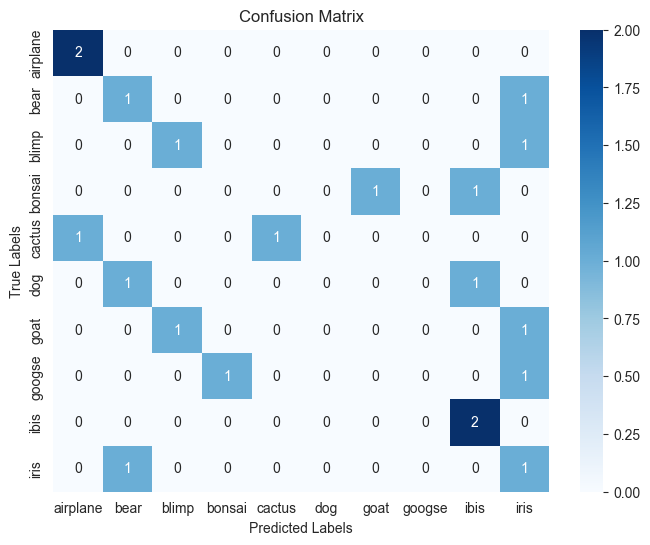

In [97]:
# Create confusion matrix
conf_matrix = confusion_matrix(y_test, my_predictions)

# Plot confusion matrix using Seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=idx2label.values(), yticklabels=idx2label.values())
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.savefig("mymodel_confusion.jpg")
plt.show()

### Comparing my model with Sklearn model

In [98]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(multi_class="ovr",max_iter=2000)
logreg.fit(X_train,y_train)

sklearn_preds = logreg.predict(X_test)

print(classification_report(y_test, sklearn_preds, target_names=idx2label.values()))

              precision    recall  f1-score   support

    airplane       0.67      1.00      0.80         2
        bear       1.00      0.50      0.67         2
       blimp       1.00      0.50      0.67         2
      bonsai       0.00      0.00      0.00         2
      cactus       0.20      0.50      0.29         2
         dog       0.00      0.00      0.00         2
        goat       0.00      0.00      0.00         2
      googse       0.00      0.00      0.00         2
        ibis       0.00      0.00      0.00         2
        iris       0.40      1.00      0.57         2

    accuracy                           0.35        20
   macro avg       0.33      0.35      0.30        20
weighted avg       0.33      0.35      0.30        20



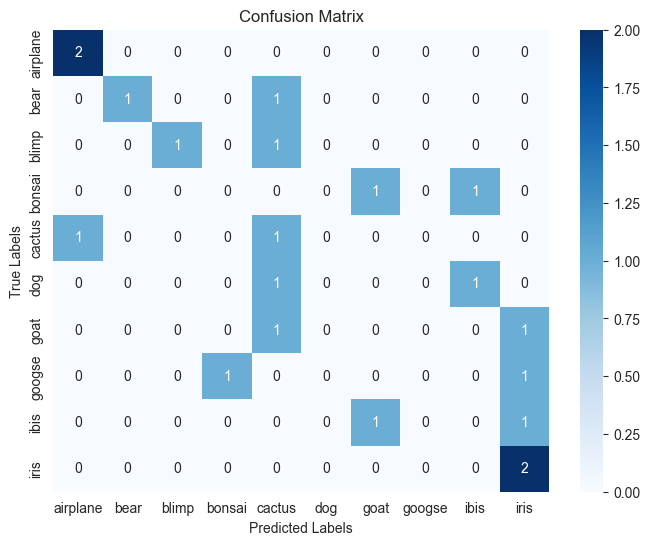

In [99]:
# Create confusion matrix
conf_matrix = confusion_matrix(y_test, sklearn_preds)

# Plot confusion matrix using Seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=idx2label.values(), yticklabels=idx2label.values())
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.savefig("sklearn_confusion.jpg")
plt.show()

**Looks like they are similar not much difference due to the parameter init, tuning**